In [576]:
%pip install numpy pandas tensorflow matplotlib scikit-learn keras statsmodels keras_tuner optuna

Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score

In [7]:
# Cargar los datos
data = pd.read_csv('datos_limpios0.csv')
data.shape

(1161, 15)

**Factores:**
- **Date**: Date in MM-DD-YYYY
- **Quarter**: A portion of the month. A month was divided into four quarters
- **Department**: Associated department with the instance
- **Day**: Day of the Week
- **Team**: Associated team number with the instance
- **Targeted productivity**: Targeted productivity set by the Authority for each team for each day.
- **SMV**: Standard Minute Value, it is the allocated time for a task
- **WIP**: Work in progress. Includes the number of unfinished items for products
- **Over time**: Represents the amount of overtime by each team in minutes
- **Incentive**: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- **Idle time**: The amount of time when the production was interrupted due to several reasons
- **Idle men**: The number of workers who were idle due to production interruption
- **No of style change**: Number of changes in the style of a particular product
- **No of workers**: Number of workers in each team

**Variable de respuesta:**
- **Actual productivity**: The actual % of productivity that was delivered by the workers. It ranges from 0-1.



In [8]:
# Convertir la columna 'Date' a tipo datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extraer día, mes y año de la columna 'Date'
data['Day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['Year'] = data['date'].dt.year

# Eliminar la columna 'Date'
data.drop(columns=['date'], inplace=True)

# Mostrar las primeras filas del DataFrame
data.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Day,Month,Year
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,1,2015
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,1,1,2015
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,1,2015


In [9]:
# Realizo una copia del DataFrame original
data_encoded = data.copy()

# Codificar las columnas categóricas en la copia
data_encoded['quarter'] = data_encoded['quarter'].astype('category').cat.codes
data_encoded['department'] = data_encoded['department'].astype('category').cat.codes
data_encoded['day'] = data_encoded['day'].astype('category').cat.codes
data_encoded['team'] = data_encoded['team'].astype('category').cat.codes

In [10]:
data_encoded.columns.tolist()

['quarter',
 'department',
 'day',
 'team',
 'targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers',
 'actual_productivity',
 'Day',
 'Month',
 'Year']

Del modelo lineal total se encontraron que las siguientes variables eran significativas, por lo que se decidio que estas fueran las escogidas para la red neuronal

In [13]:
features = ['targeted_productivity', 'smv', 'idle_men', 'no_of_workers', 'team', 'quarter', 'Month']

X = data_encoded[features]

X = pd.get_dummies(X, columns=['team', 'quarter'], dtype=int, drop_first=True)
X.head()


,targeted_productivity,smv,idle_men,no_of_workers,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4
0,0.80,26.16,0,59.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0.75,3.94,0,8.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.80,11.41,0,30.5,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.80,11.41,0,30.5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.80,25.90,0,56.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [19]:
features_Y = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'Month', 'actual_productivity']

X_more = data_encoded[features_Y]
X_more = pd.get_dummies(X_more, columns=['day', 'team', 'quarter', 'department'], dtype=int, drop_first=True)


In [20]:
X_more.shape

(1161, 31)

In [21]:
# Definir las características significativas
significant_features = [
    'targeted_productivity', 'smv', 'idle_men', 'no_of_workers', 'Month',
    'team_5', 'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'quarter_4', 'actual_productivity']


# Filtrar solo las características significativas
X_more = X_more[significant_features]

# Mostrar las primeras filas del DataFrame resultante
X_more.head()

,targeted_productivity,smv,idle_men,no_of_workers,team_5,team_6,team_7,team_8,team_9,team_10,quarter_4,actual_productivity
0,0.80,26.16,0,59.0,0,0,1,0,0,0,0,0.940725
1,0.75,3.94,0,8.0,0,0,0,0,0,0,0,0.886500
2,0.80,11.41,0,30.5,0,0,0,0,0,1,0,0.800570
3,0.80,11.41,0,30.5,0,0,0,0,0,0,0,0.800570
4,0.80,25.90,0,56.0,1,0,0,0,0,0,0,0.800382


In [22]:
Y = data_encoded["actual_productivity"]

Y.head()

0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [23]:
train = X_more.sample(frac=0.8, random_state=100)
train.head()

,targeted_productivity,smv,idle_men,no_of_workers,team_5,team_6,team_7,team_8,team_9,team_10,quarter_4,actual_productivity
892,0.8,15.26,0,34.0,0,0,0,0,0,0,0,0.800402
492,0.8,4.30,0,10.0,0,0,0,0,0,0,1,0.989000
137,0.8,19.87,0,55.0,0,0,0,0,0,0,0,0.800274
638,0.8,3.94,0,10.0,0,0,0,0,0,0,0,0.893067
918,0.7,30.33,0,58.0,0,0,0,0,0,0,0,0.662379


In [24]:
test = X_more.drop(train.index)
test.head()

,targeted_productivity,smv,idle_men,no_of_workers,team_5,team_6,team_7,team_8,team_9,team_10,quarter_4,actual_productivity
2,0.80,11.41,0,30.5,0,0,0,0,0,1,0,0.800570
11,0.75,19.31,0,54.0,0,0,0,0,1,0,0,0.712205
13,0.65,3.94,0,8.0,0,0,0,0,1,0,0,0.705917
17,0.65,23.69,0,60.0,0,0,0,0,0,0,0,0.521180
34,0.75,19.87,0,55.0,0,0,0,0,0,0,0,0.750243


In [25]:
print(train.shape)
print(test.shape)

(929, 12)
(232, 12)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable continua

In [26]:
train.describe()

,targeted_productivity,smv,idle_men,no_of_workers,team_5,team_6,team_7,team_8,team_9,team_10,quarter_4,actual_productivity
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.727417,15.149343,0.368138,34.488698,0.078579,0.086114,0.092573,0.086114,0.086114,0.075350,0.036598,0.727403
std,0.099696,11.110655,3.277420,22.288859,0.269226,0.280684,0.289989,0.280684,0.280684,0.264097,0.187875,0.169832
min,0.070000,2.900000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.233705
25%,0.700000,3.940000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.650148
50%,0.750000,15.260000,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.753683
75%,0.800000,25.900000,0.000000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.849984
max,0.800000,54.560000,45.000000,89.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.020000


Seleccionamos ahora las características y las etiquetas (MPG)

In [27]:
X_train = train.copy()
X_test = test.copy()

In [28]:
y_train = X_train.pop('actual_productivity')
y_test = X_test.pop('actual_productivity')

In [29]:
X_train.head()

,targeted_productivity,smv,idle_men,no_of_workers,team_5,team_6,team_7,team_8,team_9,team_10,quarter_4
892,0.8,15.26,0,34.0,0,0,0,0,0,0,0
492,0.8,4.30,0,10.0,0,0,0,0,0,0,1
137,0.8,19.87,0,55.0,0,0,0,0,0,0,0
638,0.8,3.94,0,10.0,0,0,0,0,0,0,0
918,0.7,30.33,0,58.0,0,0,0,0,0,0,0


In [30]:
y_train.head()

892    0.800402
492    0.989000
137    0.800274
638    0.893067
918    0.662379
Name: actual_productivity, dtype: float64

In [594]:
#from sklearn import metrics
#import statsmodels.api as sm
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.2)


## Normalizacion

In [31]:
tf.keras.layers.Normalization
norm = tf.keras.layers.Normalization()

In [32]:
norm.adapt(np.array(X_train))

In [33]:
norm.mean.numpy()

array([[ 0.7274166 , 15.1493435 ,  0.36813778, 34.488697  ,  0.07857912,
         0.0861141 ,  0.09257266,  0.0861141 ,  0.0861141 ,  0.07534984,
         0.03659849]], dtype=float32)

In [34]:
norm.variance.numpy()

array([[9.9285254e-03, 1.2331378e+02, 1.0729921e+01, 4.9625848e+02,
        7.2404437e-02, 7.8698464e-02, 8.4002964e-02, 7.8698464e-02,
        7.8698464e-02, 6.9672242e-02, 3.5259042e-02]], dtype=float32)

## Modelo lineal

In [35]:
#Importar las librerias necesarias
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from sklearn.metrics import r2_score


In [36]:
class LinearHyperModel(HyperModel):
    def build(self, hp):
        # Crear un modelo secuencial
        model = tf.keras.Sequential([
            norm,  # Capa de normalización para los datos de entrada
            tf.keras.layers.Dense(units=1)  # Capa de salida con una unidad
        ])
        # Compilar el modelo
        model.compile(
            # Optimizer Adam con tasa de aprendizaje ajustable (Se va a intentar encontrar cual es la mejor tasa de aprendizaje)
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
            # Función de pérdida ajustable (MAE o MSE)
            loss=hp.Choice('loss', ['mean_absolute_error', 'mean_squared_error'])
        )
        return model


In [37]:
def create_tuner():
    # Crear y configurar el objeto del buscador de hiperparámetros
    return BayesianOptimization(
        LinearHyperModel(),  # Modelo que se va a optimizar
        objective='val_loss',  # Minimizar la pérdida de validación
        max_trials=10,  # Número máximo de pruebas de hiperparámetros
        directory='my_dir',  # Directorio para guardar los resultados de la búsqueda
        project_name='Modelo neuronal lineal',  # Nombre del proyecto para organizar los resultados
        executions_per_trial=1  # Número de ejecuciones por cada prueba de hiperparámetros
    )

# Crear el tuner
tuner = create_tuner()

In [38]:
# Ajustar el modelo utilizando el tuner
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)

# Guardar los resultados del modelo de la mejor configuracion
bestLinearModel = tuner.get_best_models(num_models=1)[0]
bestLinearHyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

#Se guarda la mejor learning rate y loss function
bestLearningRate = bestLinearHyperparameters.get('learning_rate')
bestLossFunction = bestLinearHyperparameters.get('loss')

# Se evalua el modelo con el conjunto de prueba
test_loss = bestLinearModel.evaluate(X_train, y_train, verbose=0)

#Para encontrar el R^2 se utiliza la funcion r2_score de sklearn
yLinearPred = bestLinearModel.predict(X_test)
r2 = r2_score(y_test, yLinearPred)

resultadosOptimizador = {
    'learningRate': bestLearningRate,
    'lossFunction': bestLossFunction,
    'testLoss': test_loss,
    'r2': r2
}

Trial 10 Complete [00h 00m 04s]
val_loss: 0.018063675612211227

Best val_loss So Far: 0.018063675612211227
Total elapsed time: 00h 00m 45s
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
# Imprimir los resultados de forma bonita
print("Resultados del Optimizador:")
print(f"  - Tasa de aprendizaje: {resultadosOptimizador['learningRate']:.5f}")
print(f"  - Función de pérdida: {resultadosOptimizador['lossFunction']}")
print(f"  - Pérdida en el conjunto de prueba: {resultadosOptimizador['testLoss']:.4f}")
print(f"  - R² del modelo: {resultadosOptimizador['r2']:.4f}")

Resultados del Optimizador:
  - Tasa de aprendizaje: 0.02429
  - Función de pérdida: mean_squared_error
  - Pérdida en el conjunto de prueba: 0.0208
  - R² del modelo: 0.2330


In [42]:
linear_model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(units=1)
])

In [43]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=resultadosOptimizador['learningRate']),
    loss=resultadosOptimizador['lossFunction'])

In [44]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1717 - val_loss: 0.1413
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0843 - val_loss: 0.0262
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 0.0273 - val_loss: 0.0217
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 0.0239 - val_loss: 0.0202
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0239 - val_loss: 0.0203
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.0219 - val_loss: 0.0192
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - loss: 0.0227 - val_loss: 0.0198
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.0240 - val_loss: 0.0197
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0243 - val_loss: 0.0196
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0229 - val_loss: 0.0210
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0236 - val_loss: 0.0192
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step -

In [45]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 11)             │            23 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (252.00 B)

 Trainable params: 12 (48.00 B)

 Non-trainable params: 23 (96.00 B)

 Optimizer params: 26 (108.00 B)

In [46]:
import matplotlib.pyplot as plt

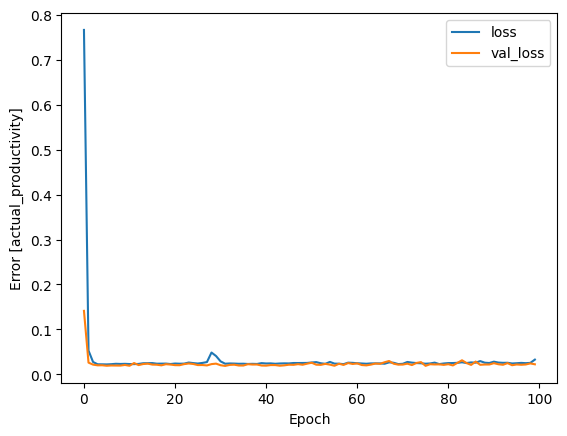

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

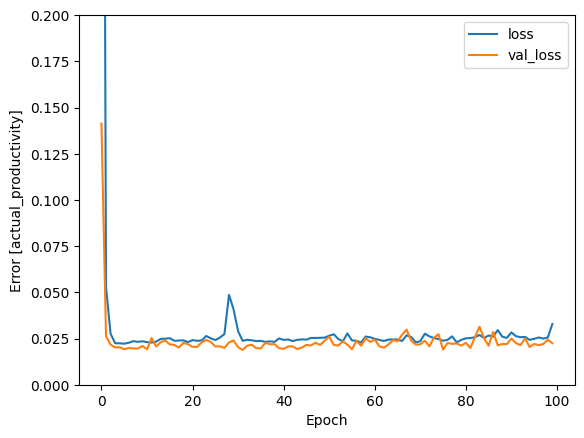

In [49]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [50]:
test_res = {}
test_res['linear_model'] = linear_model.evaluate(
    X_test,
    y_test, verbose=0)

In [51]:
test_res

{'linear_model': 0.026827877387404442}

## DNN

In [52]:
#Nueva libreria
import optuna

/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
import optuna
import tensorflow as tf
from sklearn.metrics import r2_score

# Definir la función para construir el modelo
def build_model(trial, input_shape):
    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 6)  # Número de capas ocultas
    units_per_layer = [trial.suggest_int(f'units_{i}', 16, 256) for i in range(num_layers)]  # Unidades en cada capa
    activation_function = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])  # Función de activación
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje

    # Crear el modelo secuencial
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    # Añadir las capas ocultas
    for units in units_per_layer:
        model.add(tf.keras.layers.Dense(units, activation=activation_function))

    # Añadir la capa de salida
    model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate)
    )

    return model

# Definir la función para entrenar el modelo
def train_model(model, X_train, y_train):
    # Entrenar el modelo
    history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
    )
    return history

# Definir la función para evaluar el modelo
def evaluate_model(model, X_train, y_train):
    # Hacer predicciones en el conjunto de validación
    val_predictions = model.predict(X_train)

    # Calcular el R^2
    r2 = r2_score(y_train, val_predictions)

    return r2

# Definir la función objetivo para la optimización
def objective(trial):
    # Construir el modelo
    model = build_model(trial, input_shape=(X_train.shape[1],))

    # Entrenar el modelo
    train_model(model, X_train, y_train)

    # Evaluar el modelo
    r2 = evaluate_model(model, X_train, y_train)

    return r2

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2024-10-17 09:04:02,750] A new study created in memory with name: no-name-55b3d7d9-56c8-4309-86a0-97f88ebf3295
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:04:08,306] Trial 0 finished with value: -0.07974674956867811 and parameters: {'num_layers': 4, 'units_0': 89, 'units_1': 231, 'units_2': 116, 'units_3': 138, 'activation': 'sigmoid', 'learning_rate': 3.1821531367914797e-05}. Best is trial 0 with value: -0.07974674956867811.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step


[I 2024-10-17 09:04:12,098] Trial 1 finished with value: 0.28334114960415024 and parameters: {'num_layers': 1, 'units_0': 165, 'activation': 'relu', 'learning_rate': 0.0003266041980869197}. Best is trial 1 with value: 0.28334114960415024.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:04:16,437] Trial 2 finished with value: 0.022869141713869112 and parameters: {'num_layers': 3, 'units_0': 168, 'units_1': 63, 'units_2': 230, 'activation': 'sigmoid', 'learning_rate': 0.00010476595109823042}. Best is trial 1 with value: 0.28334114960415024.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:04:21,331] Trial 3 finished with value: 0.3214392988416419 and parameters: {'num_layers': 4, 'units_0': 202, 'units_1': 129, 'units_2': 195, 'units_3': 68, 'activation': 'relu', 'learning_rate': 0.00033872101001313425}. Best is trial 3 with value: 0.3214392988416419.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:04:28,377] Trial 4 finished with value: 0.31988728192716465 and parameters: {'num_layers': 5, 'units_0': 36, 'units_1': 128, 'units_2': 234, 'units_3': 200, 'units_4': 196, 'activation': 'tanh', 'learning_rate': 0.0023885068040695426}. Best is trial 3 with value: 0.3214392988416419.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:04:35,121] Trial 5 finished with value: 0.3501366391656653 and parameters: {'num_layers': 5, 'units_0': 225, 'units_1': 254, 'units_2': 229, 'units_3': 88, 'units_4': 39, 'activation': 'relu', 'learning_rate': 3.85607877508964e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:04:39,502] Trial 6 finished with value: 0.08395108571959309 and parameters: {'num_layers': 4, 'units_0': 23, 'units_1': 69, 'units_2': 111, 'units_3': 64, 'activation': 'relu', 'learning_rate': 3.1902314149561115e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:04:45,011] Trial 7 finished with value: 0.2166688877458839 and parameters: {'num_layers': 6, 'units_0': 64, 'units_1': 87, 'units_2': 86, 'units_3': 198, 'units_4': 44, 'units_5': 231, 'activation': 'sigmoid', 'learning_rate': 0.000642141710039447}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


[I 2024-10-17 09:04:49,155] Trial 8 finished with value: 0.17251584016836785 and parameters: {'num_layers': 2, 'units_0': 119, 'units_1': 96, 'activation': 'relu', 'learning_rate': 2.1817407025418478e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:04:54,387] Trial 9 finished with value: 0.205886806903941 and parameters: {'num_layers': 3, 'units_0': 60, 'units_1': 159, 'units_2': 211, 'activation': 'tanh', 'learning_rate': 0.002949659697123653}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:05:00,900] Trial 10 finished with value: 0.2749276903779059 and parameters: {'num_layers': 6, 'units_0': 253, 'units_1': 248, 'units_2': 167, 'units_3': 26, 'units_4': 27, 'units_5': 33, 'activation': 'relu', 'learning_rate': 1.092812379215465e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:05:06,239] Trial 11 finished with value: -0.13094495894149039 and parameters: {'num_layers': 5, 'units_0': 236, 'units_1': 183, 'units_2': 29, 'units_3': 94, 'units_4': 112, 'activation': 'relu', 'learning_rate': 0.02139397005079449}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:05:12,177] Trial 12 finished with value: 0.25830833651875607 and parameters: {'num_layers': 5, 'units_0': 201, 'units_1': 197, 'units_2': 184, 'units_3': 107, 'units_4': 112, 'activation': 'relu', 'learning_rate': 0.00017759660963839643}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:05:17,422] Trial 13 finished with value: 0.23512553932954006 and parameters: {'num_layers': 4, 'units_0': 214, 'units_1': 129, 'units_2': 251, 'units_3': 19, 'activation': 'relu', 'learning_rate': 8.232099812165687e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:05:22,957] Trial 14 finished with value: -0.0009404908852321814 and parameters: {'num_layers': 5, 'units_0': 185, 'units_1': 17, 'units_2': 179, 'units_3': 143, 'units_4': 206, 'activation': 'relu', 'learning_rate': 0.06708179990328052}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2024-10-17 09:05:29,860] Trial 15 finished with value: -0.21470226026851624 and parameters: {'num_layers': 3, 'units_0': 134, 'units_1': 208, 'units_2': 198, 'activation': 'tanh', 'learning_rate': 0.0015494591693441932}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:05:35,803] Trial 16 finished with value: 0.25686984251522227 and parameters: {'num_layers': 6, 'units_0': 223, 'units_1': 157, 'units_2': 144, 'units_3': 68, 'units_4': 64, 'units_5': 20, 'activation': 'relu', 'learning_rate': 0.006435712041202702}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:05:41,022] Trial 17 finished with value: 0.0214893246613842 and parameters: {'num_layers': 2, 'units_0': 254, 'units_1': 256, 'activation': 'relu', 'learning_rate': 0.0004246764225411151}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:05:46,808] Trial 18 finished with value: 0.22186243308810627 and parameters: {'num_layers': 4, 'units_0': 183, 'units_1': 156, 'units_2': 211, 'units_3': 66, 'activation': 'tanh', 'learning_rate': 7.65827783240297e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:05:52,755] Trial 19 finished with value: -0.03231162670332255 and parameters: {'num_layers': 5, 'units_0': 141, 'units_1': 21, 'units_2': 161, 'units_3': 256, 'units_4': 150, 'activation': 'sigmoid', 'learning_rate': 1.0341674146521003e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


[I 2024-10-17 09:05:57,068] Trial 20 finished with value: 0.1344845946238724 and parameters: {'num_layers': 2, 'units_0': 198, 'units_1': 110, 'activation': 'relu', 'learning_rate': 0.00016335402027489954}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:06:03,157] Trial 21 finished with value: 0.22153711725285075 and parameters: {'num_layers': 5, 'units_0': 19, 'units_1': 138, 'units_2': 249, 'units_3': 178, 'units_4': 242, 'activation': 'tanh', 'learning_rate': 0.001358766390750415}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:06:10,490] Trial 22 finished with value: -0.6218459433552423 and parameters: {'num_layers': 5, 'units_0': 107, 'units_1': 120, 'units_2': 230, 'units_3': 223, 'units_4': 178, 'activation': 'tanh', 'learning_rate': 0.0039139430670028985}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:06:16,517] Trial 23 finished with value: -0.018694181850473557 and parameters: {'num_layers': 4, 'units_0': 159, 'units_1': 179, 'units_2': 225, 'units_3': 104, 'activation': 'tanh', 'learning_rate': 0.016075203726444512}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:06:27,948] Trial 24 finished with value: 0.2355300292467215 and parameters: {'num_layers': 6, 'units_0': 234, 'units_1': 141, 'units_2': 251, 'units_3': 159, 'units_4': 249, 'units_5': 236, 'activation': 'tanh', 'learning_rate': 0.0007139454834332371}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:06:34,262] Trial 25 finished with value: 8.752501246489519e-05 and parameters: {'num_layers': 5, 'units_0': 54, 'units_1': 220, 'units_2': 196, 'units_3': 46, 'units_4': 76, 'activation': 'tanh', 'learning_rate': 0.008192569855000364}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:06:40,658] Trial 26 finished with value: 0.31458593690951164 and parameters: {'num_layers': 4, 'units_0': 87, 'units_1': 103, 'units_2': 229, 'units_3': 115, 'activation': 'relu', 'learning_rate': 0.00179070909269733}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:06:47,813] Trial 27 finished with value: 0.27716157707281486 and parameters: {'num_layers': 6, 'units_0': 209, 'units_1': 75, 'units_2': 206, 'units_3': 83, 'units_4': 199, 'units_5': 121, 'activation': 'relu', 'learning_rate': 0.00019238573429818334}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


[I 2024-10-17 09:06:52,694] Trial 28 finished with value: 0.03690951198202641 and parameters: {'num_layers': 3, 'units_0': 186, 'units_1': 51, 'units_2': 145, 'activation': 'sigmoid', 'learning_rate': 5.1838283446095284e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:06:58,702] Trial 29 finished with value: 0.1427204411697397 and parameters: {'num_layers': 4, 'units_0': 148, 'units_1': 178, 'units_2': 45, 'units_3': 228, 'activation': 'tanh', 'learning_rate': 2.713755090847682e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:07:05,232] Trial 30 finished with value: 0.1152591168687851 and parameters: {'num_layers': 5, 'units_0': 41, 'units_1': 234, 'units_2': 182, 'units_3': 121, 'units_4': 152, 'activation': 'sigmoid', 'learning_rate': 0.0003488029193485965}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:07:10,340] Trial 31 finished with value: 0.2958318917822851 and parameters: {'num_layers': 4, 'units_0': 90, 'units_1': 108, 'units_2': 228, 'units_3': 119, 'activation': 'relu', 'learning_rate': 0.0025384371808333844}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:07:16,404] Trial 32 finished with value: 0.3411187659722299 and parameters: {'num_layers': 4, 'units_0': 81, 'units_1': 98, 'units_2': 241, 'units_3': 79, 'activation': 'relu', 'learning_rate': 0.0009577300285472485}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:07:24,536] Trial 33 finished with value: 0.20735147683791655 and parameters: {'num_layers': 3, 'units_0': 37, 'units_1': 122, 'units_2': 255, 'activation': 'relu', 'learning_rate': 0.0009115601769403936}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:07:30,123] Trial 34 finished with value: 0.26896649959651553 and parameters: {'num_layers': 4, 'units_0': 74, 'units_1': 54, 'units_2': 218, 'units_3': 81, 'activation': 'relu', 'learning_rate': 0.000471385193284944}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:07:36,373] Trial 35 finished with value: -0.04834498263640086 and parameters: {'num_layers': 5, 'units_0': 104, 'units_1': 80, 'units_2': 241, 'units_3': 56, 'units_4': 100, 'activation': 'relu', 'learning_rate': 0.007030740985776061}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step


[I 2024-10-17 09:07:40,207] Trial 36 finished with value: 0.22304677416097995 and parameters: {'num_layers': 1, 'units_0': 43, 'activation': 'relu', 'learning_rate': 0.0002257391378612884}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:07:46,387] Trial 37 finished with value: 0.20678901019692775 and parameters: {'num_layers': 4, 'units_0': 75, 'units_1': 146, 'units_2': 234, 'units_3': 36, 'activation': 'sigmoid', 'learning_rate': 0.0010098082110405365}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step 


[I 2024-10-17 09:07:55,647] Trial 38 finished with value: 0.1246160976789581 and parameters: {'num_layers': 5, 'units_0': 30, 'units_1': 93, 'units_2': 195, 'units_3': 83, 'units_4': 214, 'activation': 'relu', 'learning_rate': 4.07466883315714e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:03,147] Trial 39 finished with value: 0.2737469552848092 and parameters: {'num_layers': 6, 'units_0': 125, 'units_1': 167, 'units_2': 123, 'units_3': 163, 'units_4': 172, 'units_5': 135, 'activation': 'relu', 'learning_rate': 1.6095423283354054e-05}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:08:09,330] Trial 40 finished with value: 0.09296347212708589 and parameters: {'num_layers': 3, 'units_0': 167, 'units_1': 121, 'units_2': 99, 'activation': 'tanh', 'learning_rate': 0.0029897197039689127}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:08:16,670] Trial 41 finished with value: 0.2989745416669697 and parameters: {'num_layers': 4, 'units_0': 94, 'units_1': 105, 'units_2': 235, 'units_3': 104, 'activation': 'relu', 'learning_rate': 0.0019099096587151707}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:24,222] Trial 42 finished with value: 0.2619254561907385 and parameters: {'num_layers': 4, 'units_0': 70, 'units_1': 97, 'units_2': 218, 'units_3': 127, 'activation': 'relu', 'learning_rate': 0.0005518697510741147}. Best is trial 5 with value: 0.3501366391656653.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:08:29,288] Trial 43 finished with value: 0.3803178645213623 and parameters: {'num_layers': 4, 'units_0': 117, 'units_1': 61, 'units_2': 241, 'units_3': 141, 'activation': 'relu', 'learning_rate': 0.0012351370745936807}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:08:34,387] Trial 44 finished with value: -0.0424196865659523 and parameters: {'num_layers': 5, 'units_0': 240, 'units_1': 37, 'units_2': 239, 'units_3': 141, 'units_4': 128, 'activation': 'relu', 'learning_rate': 0.004399264524053369}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:39,943] Trial 45 finished with value: 0.22752570253321613 and parameters: {'num_layers': 4, 'units_0': 125, 'units_1': 64, 'units_2': 214, 'units_3': 194, 'activation': 'relu', 'learning_rate': 0.0009360728920559792}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step


[I 2024-10-17 09:08:44,377] Trial 46 finished with value: 0.27571335315820344 and parameters: {'num_layers': 2, 'units_0': 56, 'units_1': 89, 'activation': 'relu', 'learning_rate': 0.00011313189034548274}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:49,313] Trial 47 finished with value: -0.40352171494272393 and parameters: {'num_layers': 3, 'units_0': 111, 'units_1': 130, 'units_2': 256, 'activation': 'relu', 'learning_rate': 0.0002946857630003273}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:54,823] Trial 48 finished with value: 0.11576602970888361 and parameters: {'num_layers': 5, 'units_0': 158, 'units_1': 81, 'units_2': 203, 'units_3': 56, 'units_4': 18, 'activation': 'sigmoid', 'learning_rate': 0.0012968041932669018}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:08:59,336] Trial 49 finished with value: -0.10520863775667744 and parameters: {'num_layers': 3, 'units_0': 175, 'units_1': 31, 'units_2': 166, 'activation': 'relu', 'learning_rate': 0.013023175594167217}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:09:06,409] Trial 50 finished with value: 0.012413143368592117 and parameters: {'num_layers': 6, 'units_0': 221, 'units_1': 195, 'units_2': 243, 'units_3': 92, 'units_4': 74, 'units_5': 80, 'activation': 'relu', 'learning_rate': 0.04449071085797463}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:09:11,615] Trial 51 finished with value: 0.2908857106194319 and parameters: {'num_layers': 4, 'units_0': 97, 'units_1': 102, 'units_2': 223, 'units_3': 73, 'activation': 'relu', 'learning_rate': 0.0019784267790088745}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:09:16,768] Trial 52 finished with value: 0.15449397869485115 and parameters: {'num_layers': 4, 'units_0': 87, 'units_1': 114, 'units_2': 189, 'units_3': 98, 'activation': 'relu', 'learning_rate': 0.00388760793202936}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:09:23,317] Trial 53 finished with value: 0.29630187605232206 and parameters: {'num_layers': 4, 'units_0': 121, 'units_1': 129, 'units_2': 239, 'units_3': 117, 'activation': 'relu', 'learning_rate': 0.0007452445485716404}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:09:34,032] Trial 54 finished with value: 0.23686601061568935 and parameters: {'num_layers': 5, 'units_0': 84, 'units_1': 150, 'units_2': 73, 'units_3': 162, 'units_4': 221, 'activation': 'relu', 'learning_rate': 0.0018319658065004568}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:09:40,200] Trial 55 finished with value: 0.33747476996273873 and parameters: {'num_layers': 3, 'units_0': 136, 'units_1': 53, 'units_2': 223, 'activation': 'tanh', 'learning_rate': 0.0011772119645503802}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:09:44,556] Trial 56 finished with value: 0.2352987072951903 and parameters: {'num_layers': 3, 'units_0': 137, 'units_1': 54, 'units_2': 213, 'activation': 'tanh', 'learning_rate': 0.0011951645257877353}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:09:48,689] Trial 57 finished with value: -0.08627144974980316 and parameters: {'num_layers': 3, 'units_0': 148, 'units_1': 36, 'units_2': 245, 'activation': 'tanh', 'learning_rate': 0.005171482966551911}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step


[I 2024-10-17 09:09:53,107] Trial 58 finished with value: 0.19810944803430275 and parameters: {'num_layers': 2, 'units_0': 191, 'units_1': 44, 'activation': 'tanh', 'learning_rate': 0.002842413303838947}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:09:59,605] Trial 59 finished with value: 0.2482004504409978 and parameters: {'num_layers': 5, 'units_0': 246, 'units_1': 67, 'units_2': 222, 'units_3': 33, 'units_4': 48, 'activation': 'tanh', 'learning_rate': 0.00010582448808232045}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:10:06,459] Trial 60 finished with value: 0.08583621926070839 and parameters: {'num_layers': 3, 'units_0': 231, 'units_1': 170, 'units_2': 205, 'activation': 'tanh', 'learning_rate': 0.0006463560456946019}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:10:11,700] Trial 61 finished with value: 0.07255511030866302 and parameters: {'num_layers': 4, 'units_0': 108, 'units_1': 73, 'units_2': 225, 'units_3': 89, 'activation': 'tanh', 'learning_rate': 0.002325438330837116}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:10:17,111] Trial 62 finished with value: 0.11144935535924472 and parameters: {'num_layers': 4, 'units_0': 130, 'units_1': 85, 'units_2': 232, 'units_3': 129, 'activation': 'relu', 'learning_rate': 0.001466157412454677}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:10:23,326] Trial 63 finished with value: 0.1937381603308157 and parameters: {'num_layers': 4, 'units_0': 114, 'units_1': 115, 'units_2': 248, 'units_3': 149, 'activation': 'relu', 'learning_rate': 0.0002952150080522534}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:10:29,825] Trial 64 finished with value: 0.08952365761641212 and parameters: {'num_layers': 5, 'units_0': 50, 'units_1': 131, 'units_2': 177, 'units_3': 213, 'units_4': 187, 'activation': 'tanh', 'learning_rate': 0.00041820227439560287}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:10:34,367] Trial 65 finished with value: 0.2977485356919458 and parameters: {'num_layers': 3, 'units_0': 67, 'units_1': 99, 'units_2': 208, 'activation': 'relu', 'learning_rate': 6.316274547390085e-05}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:10:40,126] Trial 66 finished with value: 0.12351609740683867 and parameters: {'num_layers': 4, 'units_0': 210, 'units_1': 24, 'units_2': 231, 'units_3': 74, 'activation': 'sigmoid', 'learning_rate': 0.0007927112156134227}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:10:54,658] Trial 67 finished with value: 0.2992563728277613 and parameters: {'num_layers': 5, 'units_0': 16, 'units_1': 141, 'units_2': 191, 'units_3': 110, 'units_4': 153, 'activation': 'relu', 'learning_rate': 0.00013985147634301164}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:10:59,781] Trial 68 finished with value: 0.09366112489508405 and parameters: {'num_layers': 4, 'units_0': 77, 'units_1': 46, 'units_2': 244, 'units_3': 59, 'activation': 'tanh', 'learning_rate': 1.4551617997165105e-05}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:11:06,681] Trial 69 finished with value: 0.07441138466251218 and parameters: {'num_layers': 3, 'units_0': 146, 'units_1': 59, 'units_2': 151, 'activation': 'relu', 'learning_rate': 0.0011209316901542791}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:11:15,371] Trial 70 finished with value: 0.1323631555637812 and parameters: {'num_layers': 5, 'units_0': 103, 'units_1': 151, 'units_2': 221, 'units_3': 247, 'units_4': 96, 'activation': 'relu', 'learning_rate': 0.0005015056203592835}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:11:22,656] Trial 71 finished with value: 0.307683679811415 and parameters: {'num_layers': 5, 'units_0': 61, 'units_1': 217, 'units_2': 198, 'units_3': 110, 'units_4': 160, 'activation': 'relu', 'learning_rate': 0.00020654616512701994}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:11:28,697] Trial 72 finished with value: 0.28563253987843085 and parameters: {'num_layers': 5, 'units_0': 30, 'units_1': 241, 'units_2': 199, 'units_3': 109, 'units_4': 162, 'activation': 'relu', 'learning_rate': 0.001596812742200087}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:11:35,931] Trial 73 finished with value: 0.2738823487071339 and parameters: {'num_layers': 6, 'units_0': 58, 'units_1': 218, 'units_2': 213, 'units_3': 191, 'units_4': 134, 'units_5': 188, 'activation': 'relu', 'learning_rate': 0.0002645871381252524}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:11:40,953] Trial 74 finished with value: 0.26441687410763126 and parameters: {'num_layers': 4, 'units_0': 83, 'units_1': 253, 'units_2': 174, 'units_3': 131, 'activation': 'relu', 'learning_rate': 0.00041327749589545283}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


[I 2024-10-17 09:11:47,900] Trial 75 finished with value: 0.011471354643818876 and parameters: {'num_layers': 5, 'units_0': 198, 'units_1': 220, 'units_2': 229, 'units_3': 182, 'units_4': 236, 'activation': 'relu', 'learning_rate': 0.0033759216099084224}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:11:52,993] Trial 76 finished with value: 0.2393392898813267 and parameters: {'num_layers': 4, 'units_0': 63, 'units_1': 110, 'units_2': 185, 'units_3': 47, 'activation': 'tanh', 'learning_rate': 0.0002060701064206857}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:11:59,119] Trial 77 finished with value: 0.21988102706286183 and parameters: {'num_layers': 6, 'units_0': 44, 'units_1': 201, 'units_2': 251, 'units_3': 92, 'units_4': 195, 'units_5': 180, 'activation': 'sigmoid', 'learning_rate': 0.0005861286048715076}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:05,257] Trial 78 finished with value: 0.30624846372001635 and parameters: {'num_layers': 5, 'units_0': 156, 'units_1': 237, 'units_2': 236, 'units_3': 73, 'units_4': 37, 'activation': 'relu', 'learning_rate': 0.0009564515693892886}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:12:10,385] Trial 79 finished with value: 0.21770549538985584 and parameters: {'num_layers': 4, 'units_0': 29, 'units_1': 123, 'units_2': 18, 'units_3': 102, 'activation': 'relu', 'learning_rate': 0.00014511607277475376}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:17,484] Trial 80 finished with value: 0.2941740051717622 and parameters: {'num_layers': 5, 'units_0': 227, 'units_1': 228, 'units_2': 218, 'units_3': 114, 'units_4': 226, 'activation': 'relu', 'learning_rate': 3.524382484253261e-05}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:24,284] Trial 81 finished with value: 0.31719526684018695 and parameters: {'num_layers': 5, 'units_0': 177, 'units_1': 245, 'units_2': 235, 'units_3': 84, 'units_4': 37, 'activation': 'relu', 'learning_rate': 0.0022665145108852845}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:30,693] Trial 82 finished with value: 0.3669805279081051 and parameters: {'num_layers': 5, 'units_0': 202, 'units_1': 240, 'units_2': 228, 'units_3': 83, 'units_4': 60, 'activation': 'relu', 'learning_rate': 0.002125495841573102}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:12:37,308] Trial 83 finished with value: 0.3389324904507026 and parameters: {'num_layers': 5, 'units_0': 205, 'units_1': 246, 'units_2': 237, 'units_3': 83, 'units_4': 55, 'activation': 'relu', 'learning_rate': 0.005048212291358088}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:44,447] Trial 84 finished with value: 0.15014278781895374 and parameters: {'num_layers': 5, 'units_0': 216, 'units_1': 246, 'units_2': 256, 'units_3': 63, 'units_4': 53, 'activation': 'relu', 'learning_rate': 0.008886094100340882}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:12:51,143] Trial 85 finished with value: 0.22633475919596713 and parameters: {'num_layers': 6, 'units_0': 177, 'units_1': 256, 'units_2': 240, 'units_3': 80, 'units_4': 35, 'units_5': 81, 'activation': 'relu', 'learning_rate': 0.005556306771299571}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:12:57,765] Trial 86 finished with value: 0.34753609752861725 and parameters: {'num_layers': 5, 'units_0': 202, 'units_1': 241, 'units_2': 247, 'units_3': 50, 'units_4': 17, 'activation': 'relu', 'learning_rate': 0.002210267236342144}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:13:05,339] Trial 87 finished with value: -0.06587941428220123 and parameters: {'num_layers': 5, 'units_0': 205, 'units_1': 231, 'units_2': 246, 'units_3': 16, 'units_4': 21, 'activation': 'tanh', 'learning_rate': 0.009730682868951202}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step


[I 2024-10-17 09:13:08,726] Trial 88 finished with value: 0.05717369889030455 and parameters: {'num_layers': 1, 'units_0': 196, 'activation': 'relu', 'learning_rate': 0.003325674440488866}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:13:15,360] Trial 89 finished with value: 0.26594280148609484 and parameters: {'num_layers': 5, 'units_0': 216, 'units_1': 240, 'units_2': 251, 'units_3': 47, 'units_4': 60, 'activation': 'relu', 'learning_rate': 0.0013762637611226122}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:13:22,294] Trial 90 finished with value: -0.028802003631329454 and parameters: {'num_layers': 6, 'units_0': 191, 'units_1': 226, 'units_2': 227, 'units_3': 66, 'units_4': 78, 'units_5': 190, 'activation': 'tanh', 'learning_rate': 0.004209440541602238}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


[I 2024-10-17 09:13:28,823] Trial 91 finished with value: 0.3118463996089228 and parameters: {'num_layers': 5, 'units_0': 180, 'units_1': 242, 'units_2': 235, 'units_3': 87, 'units_4': 33, 'activation': 'relu', 'learning_rate': 0.002259731326989192}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:13:35,296] Trial 92 finished with value: 0.28697974154647565 and parameters: {'num_layers': 5, 'units_0': 206, 'units_1': 248, 'units_2': 236, 'units_3': 53, 'units_4': 45, 'activation': 'relu', 'learning_rate': 0.001953285996066219}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:13:41,283] Trial 93 finished with value: 0.2747043978326519 and parameters: {'num_layers': 5, 'units_0': 222, 'units_1': 254, 'units_2': 129, 'units_3': 78, 'units_4': 26, 'activation': 'relu', 'learning_rate': 0.006471062556886841}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 09:13:47,906] Trial 94 finished with value: 0.31313020550140214 and parameters: {'num_layers': 5, 'units_0': 188, 'units_1': 212, 'units_2': 244, 'units_3': 37, 'units_4': 61, 'activation': 'relu', 'learning_rate': 0.002690349623763611}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:13:54,895] Trial 95 finished with value: 0.3130565684620191 and parameters: {'num_layers': 5, 'units_0': 169, 'units_1': 244, 'units_2': 217, 'units_3': 97, 'units_4': 39, 'activation': 'relu', 'learning_rate': 0.005229720788523355}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:14:05,752] Trial 96 finished with value: 0.36767058669769126 and parameters: {'num_layers': 5, 'units_0': 201, 'units_1': 248, 'units_2': 229, 'units_3': 69, 'units_4': 94, 'activation': 'relu', 'learning_rate': 0.0016142621695656191}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:14:11,996] Trial 97 finished with value: 0.0018625082572314433 and parameters: {'num_layers': 4, 'units_0': 201, 'units_1': 250, 'units_2': 225, 'units_3': 69, 'activation': 'sigmoid', 'learning_rate': 0.0008112686979676791}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:14:18,092] Trial 98 finished with value: 0.2186448623795758 and parameters: {'num_layers': 5, 'units_0': 246, 'units_1': 234, 'units_2': 210, 'units_3': 24, 'units_4': 97, 'activation': 'relu', 'learning_rate': 0.0015792393655260834}. Best is trial 43 with value: 0.3803178645213623.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/485115105.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 09:14:25,275] Trial 99 finished with value: -0.2876514310535674 and parameters: {'num_layers': 6, 'units_0': 214, 'units_1': 236, 'units_2': 230, 'units_3': 171, 'units_4': 87, 'units_5': 79, 'activation': 'tanh', 'learning_rate': 0.0036158690880146852}. Best is trial 43 with value: 0.3803178645213623.


In [58]:
# Supongamos que estos son los mejores hiperparámetros y el mejor R^2 obtenidos del estudio
best_params = study.best_params
best_r2 = study.best_value

# Imprimir los mejores hiperparámetros de manera legible
print("Mejores hiperparámetros:")
print(f"  - Número de capas ocultas: {best_params['num_layers']}")
for i in range(best_params['num_layers']):
    print(f"  - Unidades en la capa {i}: {best_params[f'units_{i}']}")
    print(f"  - Función de activación: {best_params['activation']}")
print(f"  - Tasa de aprendizaje: {best_params['learning_rate']:.8f}")
print(f"Mejor R^2: {best_r2:.6f}")
print(best_params)

Mejores hiperparámetros:
  - Número de capas ocultas: 4
  - Unidades en la capa 0: 117
  - Función de activación: relu
  - Unidades en la capa 1: 61
  - Función de activación: relu
  - Unidades en la capa 2: 241
  - Función de activación: relu
  - Unidades en la capa 3: 141
  - Función de activación: relu
  - Tasa de aprendizaje: 0.00123514
Mejor R^2: 0.380318
{'num_layers': 4, 'units_0': 117, 'units_1': 61, 'units_2': 241, 'units_3': 141, 'activation': 'relu', 'learning_rate': 0.0012351370745936807}


#### Intento 2

In [55]:
import optuna

# Definimos la función objetivo para la optimización
def objective(trial):
    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 5)  # Número de capas ocultas
    units = [trial.suggest_int(f'units_{i}', 32, 128) for i in range(num_layers)]  # Unidades en cada capa
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])  # Función de activación
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje

    # Construir el modelo
    dnn_model = tf.keras.Sequential()
    dnn_model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Añadir las capas ocultas
    for units in units:
        dnn_model.add(tf.keras.layers.Dense(units, activation=activation))

    # Capa de salida
    dnn_model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo
    dnn_model.compile(loss='mean_absolute_error',
                      optimizer=tf.keras.optimizers.Adam(learning_rate))

    # Entrenar el modelo
    history = dnn_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
    )

    # Hacer predicciones en el conjunto de validación
    val_predictions = dnn_model.predict(X_train)

    # Calcular el R^2
    r2 = r2_score(y_train, val_predictions)

    return r2

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor R^2:", study.best_value)

# Puedes usar los mejores hiperparámetros para entrenar tu modelo final


[I 2024-10-17 09:02:08,128] A new study created in memory with name: no-name-bf7d9834-339e-400c-93ef-be718c795923
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:13,190] Trial 0 finished with value: -0.08722373764211988 and parameters: {'num_layers': 3, 'units_0': 63, 'units_1': 76, 'units_2': 122, 'activation': 'sigmoid', 'learning_rate': 0.01786530324577771}. Best is trial 0 with value: -0.08722373764211988.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-10-17 09:02:17,356] Trial 1 finished with value: 0.20011119017076506 and parameters: {'num_layers': 3, 'units_0': 95, 'units_1': 102, 'units_2': 78, 'activation': 'sigmoid', 'learning_rate': 0.03077619907183459}. Best is trial 1 with value: 0.20011119017076506.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:21,439] Trial 2 finished with value: 0.05314394490059693 and parameters: {'num_layers': 4, 'units_0': 40, 'units_1': 101, 'units_2': 34, 'units_3': 107, 'activation': 'relu', 'learning_rate': 0.0013727832452688868}. Best is trial 1 with value: 0.20011119017076506.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


[I 2024-10-17 09:02:25,468] Trial 3 finished with value: 0.12006996444358531 and parameters: {'num_layers': 3, 'units_0': 65, 'units_1': 96, 'units_2': 113, 'activation': 'tanh', 'learning_rate': 0.009784265892346286}. Best is trial 1 with value: 0.20011119017076506.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:02:29,676] Trial 4 finished with value: 0.2501782183070381 and parameters: {'num_layers': 5, 'units_0': 72, 'units_1': 65, 'units_2': 37, 'units_3': 72, 'units_4': 81, 'activation': 'relu', 'learning_rate': 0.00028745650219947965}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:02:33,943] Trial 5 finished with value: 0.0589471331749194 and parameters: {'num_layers': 4, 'units_0': 35, 'units_1': 126, 'units_2': 63, 'units_3': 46, 'activation': 'relu', 'learning_rate': 0.03904632345354569}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:38,997] Trial 6 finished with value: 0.180386520338643 and parameters: {'num_layers': 3, 'units_0': 73, 'units_1': 96, 'units_2': 90, 'activation': 'relu', 'learning_rate': 6.230076753806054e-05}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:42,585] Trial 7 finished with value: 0.0047189794156689 and parameters: {'num_layers': 2, 'units_0': 42, 'units_1': 43, 'activation': 'tanh', 'learning_rate': 2.19396101178722e-05}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 09:02:46,773] Trial 8 finished with value: 0.2315677362456342 and parameters: {'num_layers': 4, 'units_0': 107, 'units_1': 49, 'units_2': 52, 'units_3': 112, 'activation': 'tanh', 'learning_rate': 8.614869599741322e-05}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:51,192] Trial 9 finished with value: -0.3562105414700678 and parameters: {'num_layers': 4, 'units_0': 35, 'units_1': 89, 'units_2': 92, 'units_3': 80, 'activation': 'tanh', 'learning_rate': 0.02459719680242477}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:55,479] Trial 10 finished with value: 0.21272651308141233 and parameters: {'num_layers': 5, 'units_0': 124, 'units_1': 64, 'units_2': 32, 'units_3': 59, 'units_4': 81, 'activation': 'relu', 'learning_rate': 0.0006845410229454887}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 09:02:59,977] Trial 11 finished with value: 0.217443665207409 and parameters: {'num_layers': 5, 'units_0': 97, 'units_1': 33, 'units_2': 53, 'units_3': 121, 'units_4': 62, 'activation': 'tanh', 'learning_rate': 0.00024905830249113996}. Best is trial 4 with value: 0.2501782183070381.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step


[I 2024-10-17 09:03:03,361] Trial 12 finished with value: 0.26411031713807764 and parameters: {'num_layers': 1, 'units_0': 123, 'activation': 'relu', 'learning_rate': 0.00014601900510844974}. Best is trial 12 with value: 0.26411031713807764.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


[I 2024-10-17 09:03:06,619] Trial 13 finished with value: 0.3143340936630624 and parameters: {'num_layers': 1, 'units_0': 128, 'activation': 'relu', 'learning_rate': 0.0021710076655085575}. Best is trial 13 with value: 0.3143340936630624.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step


[I 2024-10-17 09:03:09,911] Trial 14 finished with value: -0.001221444971547081 and parameters: {'num_layers': 1, 'units_0': 128, 'activation': 'relu', 'learning_rate': 0.0032917421984723725}. Best is trial 13 with value: 0.3143340936630624.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


[I 2024-10-17 09:03:13,190] Trial 15 finished with value: 0.19567657585136222 and parameters: {'num_layers': 1, 'units_0': 117, 'activation': 'relu', 'learning_rate': 0.0012806641893493024}. Best is trial 13 with value: 0.3143340936630624.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step


[I 2024-10-17 09:03:17,073] Trial 16 finished with value: 0.31589396799304903 and parameters: {'num_layers': 2, 'units_0': 107, 'units_1': 128, 'activation': 'relu', 'learning_rate': 0.004811754563217256}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step


[I 2024-10-17 09:03:21,141] Trial 17 finished with value: 0.2557604941363417 and parameters: {'num_layers': 2, 'units_0': 106, 'units_1': 127, 'activation': 'sigmoid', 'learning_rate': 0.004758646899129896}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step


[I 2024-10-17 09:03:25,010] Trial 18 finished with value: 0.2845688545281623 and parameters: {'num_layers': 2, 'units_0': 88, 'units_1': 114, 'activation': 'relu', 'learning_rate': 0.0030230352200970533}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step


[I 2024-10-17 09:03:28,931] Trial 19 finished with value: -0.014288795426202094 and parameters: {'num_layers': 2, 'units_0': 111, 'units_1': 114, 'activation': 'relu', 'learning_rate': 0.08638671614116875}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step


[I 2024-10-17 09:03:32,531] Trial 20 finished with value: 0.11139807736903384 and parameters: {'num_layers': 1, 'units_0': 115, 'activation': 'sigmoid', 'learning_rate': 0.007650744522059848}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step


[I 2024-10-17 09:03:36,329] Trial 21 finished with value: 0.20897876503460933 and parameters: {'num_layers': 2, 'units_0': 88, 'units_1': 114, 'activation': 'relu', 'learning_rate': 0.0026808984971306944}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


[I 2024-10-17 09:03:40,114] Trial 22 finished with value: 0.17016830212016087 and parameters: {'num_layers': 2, 'units_0': 88, 'units_1': 114, 'activation': 'relu', 'learning_rate': 0.000626203708523851}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step


[I 2024-10-17 09:03:43,571] Trial 23 finished with value: 0.13068396877092958 and parameters: {'num_layers': 1, 'units_0': 104, 'activation': 'relu', 'learning_rate': 0.0023707389325722653}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step


[I 2024-10-17 09:03:47,614] Trial 24 finished with value: 0.2639078151599762 and parameters: {'num_layers': 2, 'units_0': 97, 'units_1': 119, 'activation': 'relu', 'learning_rate': 0.008926055064663282}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step


[I 2024-10-17 09:03:51,198] Trial 25 finished with value: 0.203792561685734 and parameters: {'num_layers': 1, 'units_0': 87, 'activation': 'relu', 'learning_rate': 0.0014134057866569956}. Best is trial 16 with value: 0.31589396799304903.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_7884/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
[W 2024-10-17 09:03:53,226] Trial 26 failed with parameters: {'num_layers': 2, 'units_0': 117, 'units_1': 83, 'activation

KeyboardInterrupt: 

## Empleando los mejores hiperparametros

Modelo con multiples varaibles de entrada

In [59]:
dnn_model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(4, activation='relu'),
      tf.keras.layers.Dense(117, activation='relu'),
      tf.keras.layers.Dense(61, activation='relu'),
      tf.keras.layers.Dense(141, activation='relu'),
      tf.keras.layers.Dense(1)
  ])

In [60]:
dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(best_params['learning_rate']))


In [61]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.5363 - val_loss: 0.2141
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1855 - val_loss: 0.1213
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1213 - val_loss: 0.1066
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1135 - val_loss: 0.1200
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1235 - val_loss: 0.1053
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1047 - val_loss: 0.1132
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1094 - val_loss: 0.1048
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1112 - val_loss: 0.1042
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1031 - val_loss: 0.1123
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1076 - val_loss: 0.1005
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1080 - val_loss: 0.1031
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1

In [62]:
dnn_model.summary()

Model: "sequential_174"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 11)             │            23 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_804 (Dense)               │ (None, 4)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_805 (Dense)               │ (None, 117)            │           585 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_806 (Dense)               │ (None, 61)             │         7,198 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_807 (Dense)               │ (None, 141)            │         8,742 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_808 (Dense)               │ (None, 1)              │           142 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,170 (195.98 KB)

 Trainable params: 16,715 (65.29 KB)

 Non-trainable params: 23 (96.00 B)

 Optimizer params: 33,432 (130.60 KB)

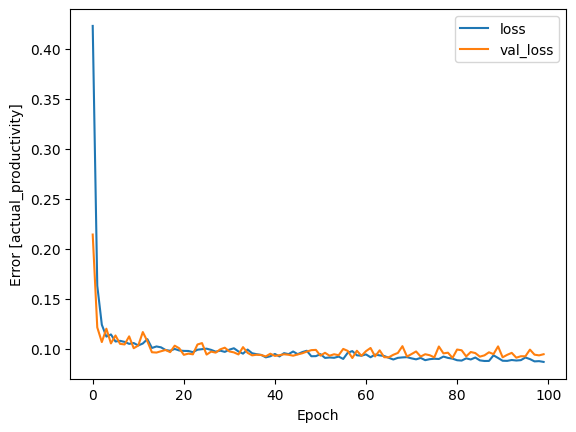

In [63]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [64]:
test_res['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [65]:
test_res

{'linear_model': 0.026827877387404442, 'dnn_model': 0.09883074462413788}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


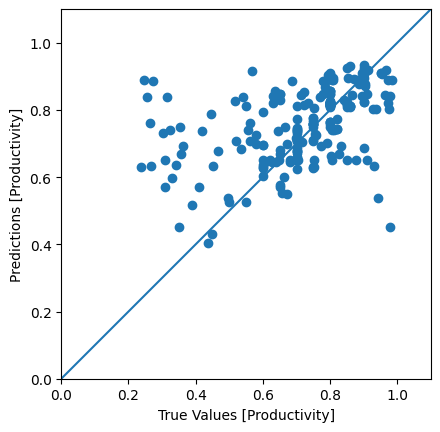

In [66]:
test_pred = dnn_model.predict(X_test).flatten()

plt.axes(aspect='equal')
plt.scatter(y_test, test_pred)
plt.xlabel('True Values [Productivity]')
plt.ylabel('Predictions [Productivity]')
lims = [0, 1.1]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

## Evaluacion de los modelos

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [68]:
#Prediccion del modelo lineal
linear_model_pred = linear_model.predict(X_test).flatten()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [69]:
# Calcular métricas para el modelo lineal
mae_ml = mean_absolute_error(y_test, linear_model_pred)
mse_ml = mean_squared_error(y_test, linear_model_pred)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(y_test, linear_model_pred)


In [70]:
#Evaluacion del modelo DNN
dnn_model_pred= dnn_model.predict(X_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


In [71]:
# Calcular métricas para el modelo DNN
mae_dnn = mean_absolute_error(y_test, dnn_model_pred)
mse_dnn = mean_squared_error(y_test, dnn_model_pred)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(y_test, dnn_model_pred)

In [72]:
# Create a DataFrame to compare the metrics of the models
metrics_comparison = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R^2 Score'],
    'Linear Model': [mae_ml, mse_ml, rmse_ml, r2_ml],
    'DNN Model': [mae_dnn, mse_dnn, rmse_dnn, r2_dnn]
})

# Print the DataFrame
print(metrics_comparison)

                           Metric  Linear Model  DNN Model
0       Mean Absolute Error (MAE)      0.118720   0.098831
1        Mean Squared Error (MSE)      0.026828   0.024402
2  Root Mean Squared Error (RMSE)      0.163792   0.156212
3                       R^2 Score      0.053292   0.138888
